In [1]:
from functions import *
from functions.ipa import calculate_ipa,calculate_rolling_ipa

import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats
from pathlib import Path

import pingouin as pg
import seaborn as sns

import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import pearsonr
from scipy.stats import linregress


In [2]:
# Define paths
BASE_PATH = Path("Z:/yueying/psychedeLights_YueyingDong")
PSYCHOPY_PATH = BASE_PATH / "results/data/psychopy"
SACC_CLEAN_PATH = BASE_PATH / "results/data/saccClean"
GAZE_CLEAN_PATH = BASE_PATH / "results/data/gazeClean"
PUPIL_RAW_PATH = BASE_PATH / "pupRaw_formatted"


In [3]:
sacc_clean_files = glob.glob(str(SACC_CLEAN_PATH / "*.csv"))
saccClean = pd.concat(
    [pd.read_csv(f).iloc[:, 1:] for f in sacc_clean_files],
    axis=0,
    ignore_index=True
)
print(f"  Loaded {len(saccClean)} trials from {len(sacc_clean_files)} files")

print("\n✓ Data loading complete!")

  Loaded 35924 trials from 3 files

✓ Data loading complete!


In [4]:
gaze_clean_files = glob.glob(str(GAZE_CLEAN_PATH / "*.csv"))
gazeClean = pd.concat(
    [pd.read_csv(f) for f in gaze_clean_files],
    axis=0,
    ignore_index=True
)
print(f"  Loaded {len(gazeClean)} trials from {len(gaze_clean_files)} files")

print("\n✓ Data loading complete!")

  Loaded 18112 trials from 2 files

✓ Data loading complete!


In [5]:
psyFull = pd.read_csv('./psychopy/psyFull.csv')

# Figure 4A

In [6]:
gazeTemp = gazeClean.reset_index().merge(psyFull[['TRIALID','cuedItem',]]).set_index(['cuedItem','axis'])

C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_20104\1760433172.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  allX = gazeTemp.iloc[:,4001:7501].loc['left','x'].to_numpy().flatten()-960
C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_20104\1760433172.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  allY = gazeTemp.iloc[:,4001:7501].loc['left','y'].to_numpy().flatten()-520


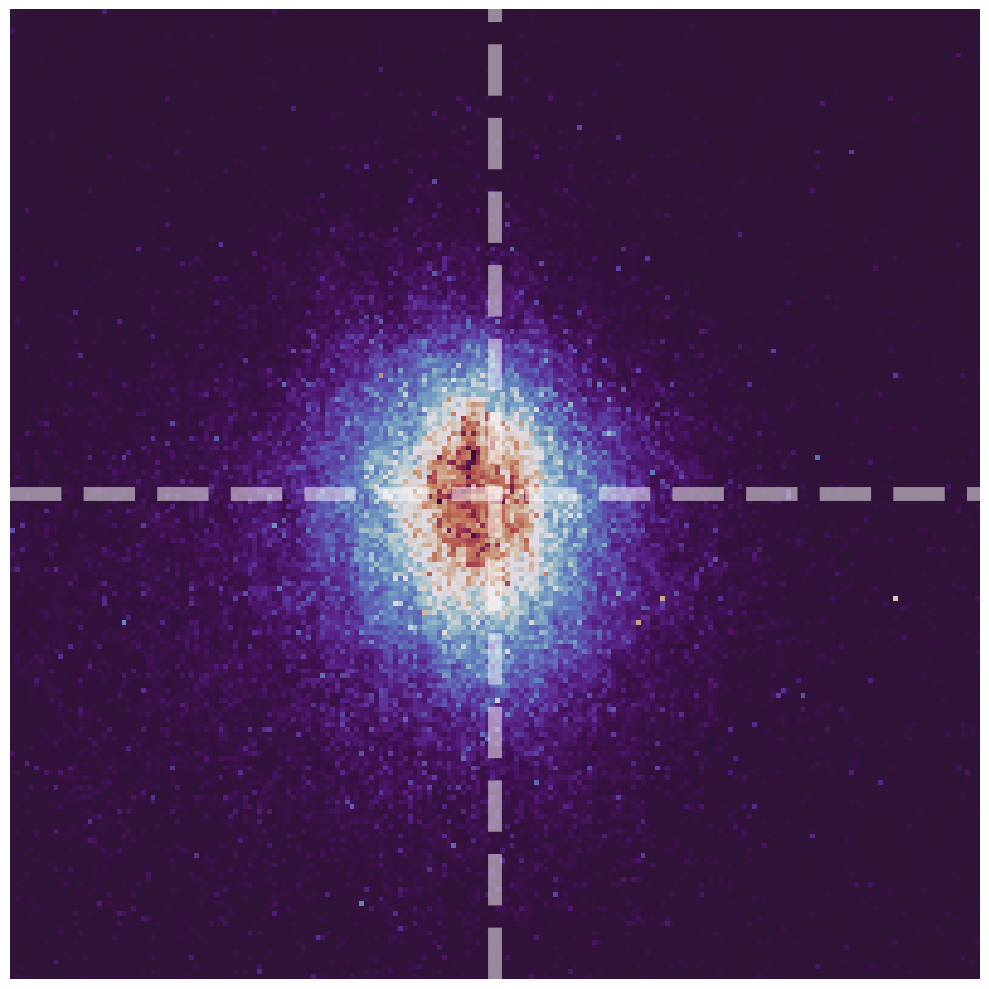

In [7]:
fs(10,10)

allX = gazeTemp.iloc[:,4001:7501].loc['left','x'].to_numpy().flatten()-960
allY = gazeTemp.iloc[:,4001:7501].loc['left','y'].to_numpy().flatten()-520

fig,ax = plt.subplots(1)
leftVal = plt.hist2d(allX, allY, bins = (200,200),
                         range = [[-100, 100], [-100, 100]], density=True,cmap = 'twilight_shifted')[0]
plt.vlines(0,-100,100,linestyles='dashed',colors = 'white',linewidth = 10,alpha = 0.5)
plt.hlines(0,-100,100,linestyles='dashed',colors = 'white',linewidth = 10,alpha = 0.5)

plt.axis('off')

plt.tick_params(labelsize = 40)
fig.tight_layout()
plt.show()


C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_20104\453335880.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  allX = gazeTemp.iloc[:,4001:7501].loc['right','x'].to_numpy().flatten()-960
C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_20104\453335880.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  allY = gazeTemp.iloc[:,4001:7501].loc['right','y'].to_numpy().flatten()-520


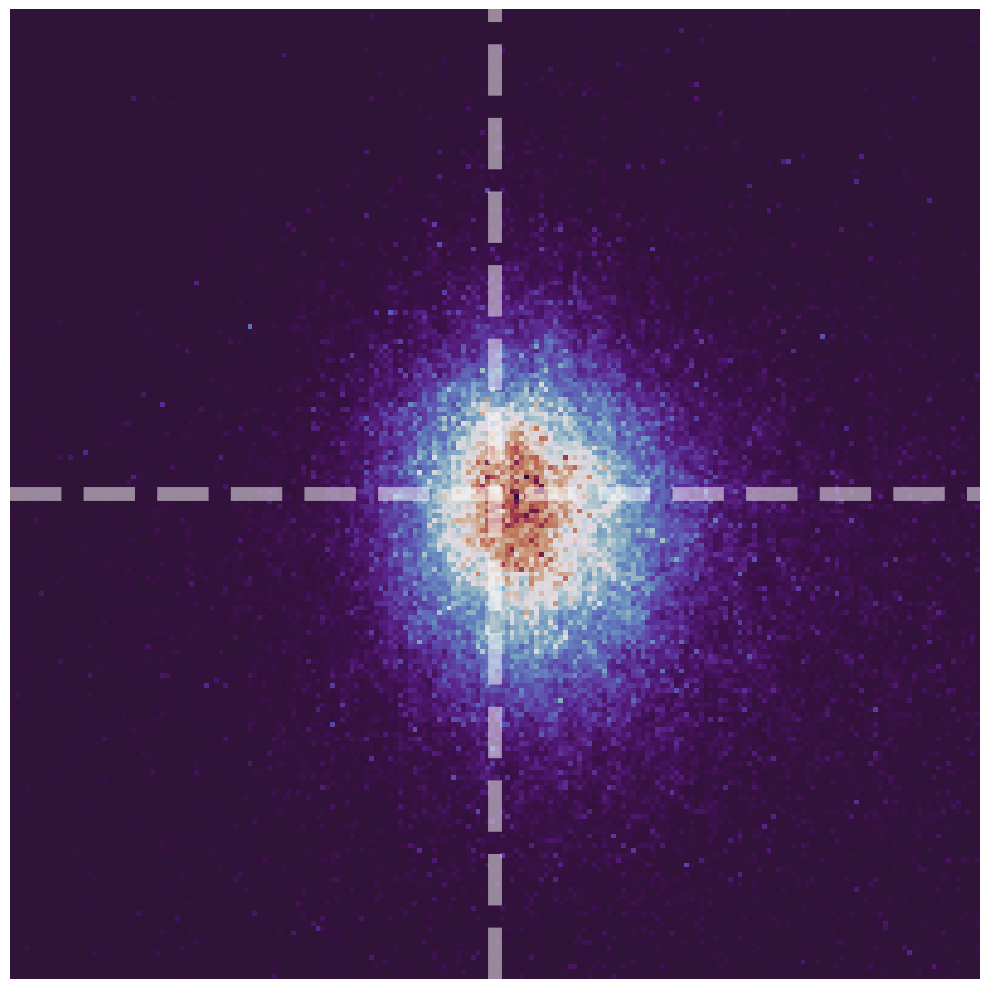

In [8]:
fs(10,10)

allX = gazeTemp.iloc[:,4001:7501].loc['right','x'].to_numpy().flatten()-960
allY = gazeTemp.iloc[:,4001:7501].loc['right','y'].to_numpy().flatten()-520

fig,ax = plt.subplots(1)
rightVal = plt.hist2d(allX, allY, bins = (200,200),
                         range = [[-100, 100], [-100, 100]], density=True,cmap = 'twilight_shifted')[0]
plt.vlines(0,-100,100,linestyles='dashed',colors = 'white',linewidth = 10,alpha = 0.5)
plt.hlines(0,-100,100,linestyles='dashed',colors = 'white',linewidth = 10,alpha = 0.5)


plt.axis('off')

plt.tick_params(labelsize = 40)
fig.tight_layout()
plt.show()


(-0.5, 210.025, 210.025, -0.5)

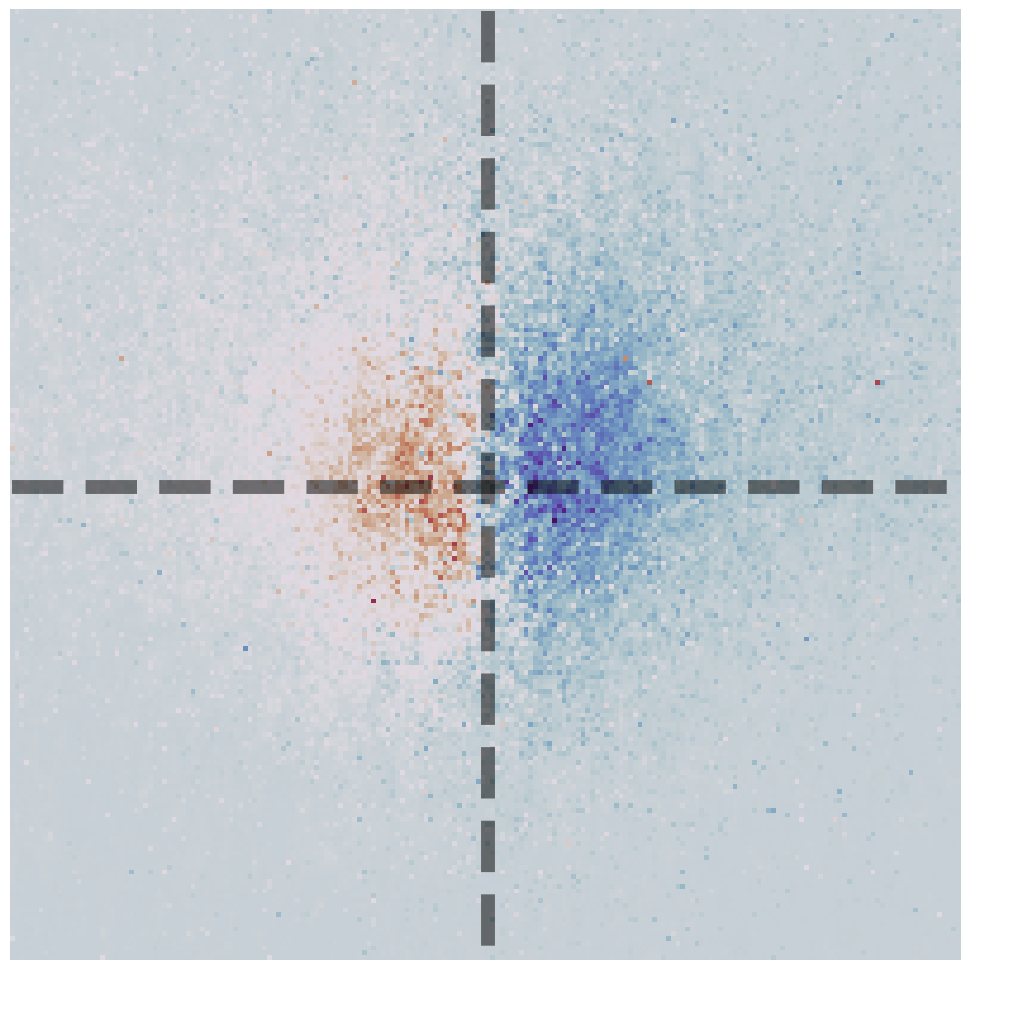

In [9]:
fs(13,13)

plt.imshow((leftVal - rightVal).T,cmap='twilight_shifted',vmin = -0.00032,vmax = 0.0004)
plt.vlines(100,0,200,linestyles='dashed',colors = 'black',linewidth = 10,alpha = 0.5)
plt.hlines(100,0,200,linestyles='dashed',colors = 'black',linewidth = 10,alpha = 0.5)

plt.axis('off')


# Figure 4B

In [10]:
gazeClean.set_index('axis',inplace=True)

In [11]:
shift_df = calculate_gaze_shifts(gazeClean)

GAZE SHIFT CALCULATION

Step 1: Smoothing gaze data (window=51)...
  Smoothed 9056 trials
Step 2: Detecting gaze shifts (threshold=6px)...
Step 3: Filtering shifts (X≥8px or Y≥8px)...
  Detected 167,123 X-shifts and 167,120 Y-shifts
Step 4: Formatting output...

GAZE SHIFT CALCULATION COMPLETE
Output shape: (18112, 8002)
Trials with shifts: 9056


In [12]:
shiftDf = shift_df[shift_df.axis == 'x'].iloc[:,1:].merge(psyFull[['TRIALID','cuedItem']],on='TRIALID')
shiftDf = shiftDf.set_index('cuedItem')

toward = shiftDf.copy()
away = shiftDf.copy()

leftAll = toward.loc['left'].iloc[:,2:].values
toward.loc['left',toward.columns[2:]] = np.where(leftAll < 0,1,0)
rightAll = toward.loc['right'].iloc[:,2:].values
toward.loc['right',toward.columns[2:]] = np.where(rightAll > 0,1,0)

leftAll = away.loc['left'].iloc[:,2:].values
away.loc['left',away.columns[2:]] = np.where(leftAll > 0,1,0)
rightAll = away.loc['right'].iloc[:,2:].values
away.loc['right', away.columns[2:]] = np.where(rightAll <0,1,0)

#get frequency
winsize = 100
freq = 1000
towardFreq = toward.iloc[:,1:].rolling(window = winsize,min_periods = winsize,axis = 1).sum()*freq/winsize
awayFreq = away.iloc[:,1:].rolling(window = winsize,min_periods = winsize,axis = 1).sum()*freq/winsize

towardFreq.insert(0,'TRIALID',toward.TRIALID)
awayFreq.insert(0,'TRIALID',away.TRIALID)
towardFreq['towardness'] = 'toward'
awayFreq['towardness'] = 'away'
towardnessDf = pd.concat([towardFreq,awayFreq],axis = 0)
towardnessDf = towardnessDf.reset_index()
towardnessDf = towardnessDf.merge(psyFull[['trlType','TRIALID']])

C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_20104\3830987711.py:20: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  towardFreq = toward.iloc[:,1:].rolling(window = winsize,min_periods = winsize,axis = 1).sum()*freq/winsize
C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_20104\3830987711.py:21: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  awayFreq = away.iloc[:,1:].rolling(window = winsize,min_periods = winsize,axis = 1).sum()*freq/winsize


### Frequency of saccades-toward-cued-direction by trial type (visual vs semantic)

In [13]:
dataN = 35

a = towardnessDf[towardnessDf.towardness == 'toward'].iloc[:,2:3502]
a.columns = range(a.shape[1])
a = a.groupby(a.columns // 100, axis=1).mean()
dsSacc = pd.concat([a,towardnessDf[towardnessDf.towardness == 'toward'][['trlType']]],axis = 1)

C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_20104\1678369004.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  a = a.groupby(a.columns // 100, axis=1).mean()


In [14]:
result = cluster_permutation_test(
    data_df=dsSacc,
    condition_column='trlType',
    condition_values=('visual', 'verbal'),
    n_permutations=5000,
    data_columns=slice(0, 35),  # 35 downsampled bins
    p_threshold=0.05,
    seed=42
)

Running cluster permutation test:
  Conditions: visual vs verbal
  Timepoints: 35
  Permutations: 5000
  P-threshold: 0.05

Computing observed statistics...
  Largest observed cluster: 1 timepoints (indices 29-29), statistic=2.867
  Largest observed cluster: 1 timepoints (indices 29-29), statistic=2.867

Running 5000 permutations...
  Progress: 1000/5000
  Progress: 2000/5000
  Progress: 3000/5000
  Progress: 4000/5000
  Progress: 5000/5000

RESULTS:
  Observed largest cluster statistic: 2.867
  Permutation p-value: 0.2032


In [15]:
cluster_pvalues = [
    np.mean(cluster_stat > result['null_distribution'])
    for cluster_stat in [result['observed_stats'][cluster].sum() 
                         for cluster in result['observed_clusters']]
]

cluster_t = [time for time, p in zip(result['observed_clusters'], cluster_pvalues) if p < 0.05]
cluster_t = [(i[0]/10,i[-1]/10+0.1) #since the array starts at 0, plus 0.1
    for i in cluster_t]

print("Cluster p-values:", cluster_pvalues)
print("Clusters:", cluster_t)

Cluster p-values: [0.8982]
Clusters: []


In [16]:
qq = towardnessDf.groupby(['towardness','trlType']).mean(numeric_only=True)
qqSd = towardnessDf.groupby(['towardness','trlType']).sem(numeric_only=True)

saccUpper = qq + qqSd
saccLower = qq - qqSd

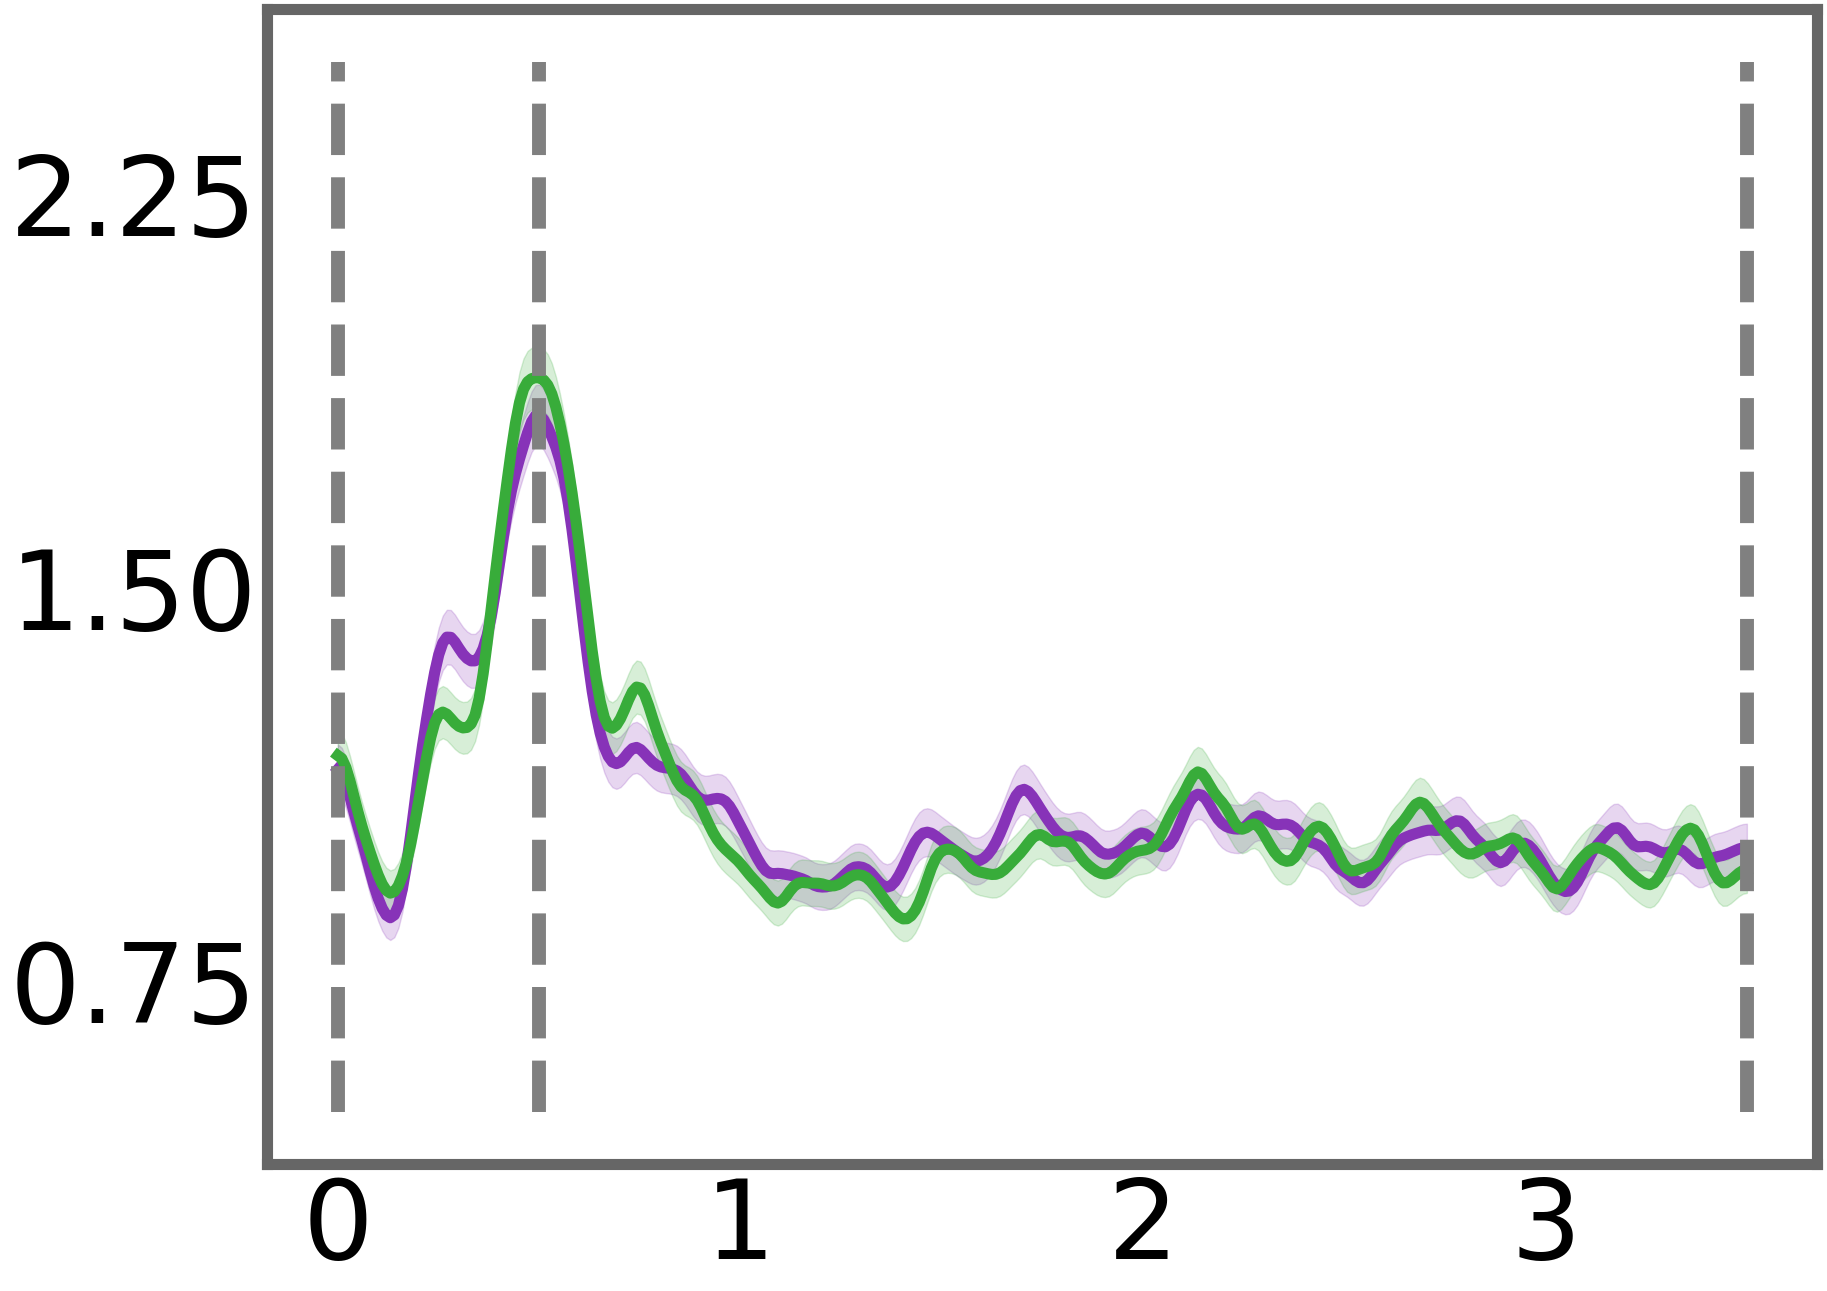

In [17]:
fs(20,15)
fig,ax = plt.subplots()

lenData = 350
x = np.linspace(0,3.5,lenData)
[plt.plot(x,smooth_signal(qq.iloc[i,4001:7501:10],11),c = ["#8733b8","#38ac3a",][i%2],linestyle = ['dotted','-'][i//2],alpha=[0.8,0.8,1,1,][i],linewidth = 8) for i in [2,3]];
[plt.fill_between(x,smooth_signal(saccUpper.iloc[i,4001:7501:10]),
                       smooth_signal(saccLower.iloc[i,4001:7501:10]),alpha = 0.2,color = ["#8733b8","#38ac3a",][i%2]) for i in [2,3]]

[plt.fill_between(i,2.0,2.25,color = "#949494",alpha = 0.2) for i in cluster_t]


plt.vlines([0,0.5,3.5],0.5,2.5,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=80)
plt.xticks(fontsize=80)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.75))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(8)
ax.spines['bottom'].set_linewidth(8)
ax.spines['right'].set_linewidth(8)
ax.spines['top'].set_linewidth(8)

### Frequency of saccades-toward-cued-direction by cued item type (day vs night)

In [18]:
towardnessDf_bri = towardnessDf.merge(psyFull[['TRIALID','cuedItemBri','participant']],how = 'left')

In [19]:
dsSacc = pd.concat([a,towardnessDf_bri[towardnessDf_bri.towardness == 'toward'][['cuedItemBri']]],axis = 1)
result = cluster_permutation_test(
    data_df=dsSacc,
    condition_column='cuedItemBri',
    condition_values=('day', 'night'),
    n_permutations=5000,
    data_columns=slice(0, 35),  # 35 downsampled bins
    p_threshold=0.05,
    seed=42
)

Running cluster permutation test:
  Conditions: day vs night
  Timepoints: 35
  Permutations: 5000
  P-threshold: 0.05

Computing observed statistics...
  Largest observed cluster: 2 timepoints (indices 5-6), statistic=6.223
  Largest observed cluster: 2 timepoints (indices 5-6), statistic=6.223

Running 5000 permutations...
  Progress: 1000/5000
  Progress: 2000/5000
  Progress: 3000/5000
  Progress: 4000/5000
  Progress: 5000/5000

RESULTS:
  Observed largest cluster statistic: 6.223
  Permutation p-value: 0.0046


In [20]:
cluster_pvalues = [
    np.mean(cluster_stat > result['null_distribution'])
    for cluster_stat in [result['observed_stats'][cluster].sum() 
                         for cluster in result['observed_clusters']]
]

cluster_t = [time for time, p in zip(result['observed_clusters'], cluster_pvalues) if p < 0.05]
cluster_t = [(i[0]/10,i[-1]/10+0.1) #since the array starts at 0, plus 0.1
    for i in cluster_t]

print("Cluster p-values:", cluster_pvalues)
print("Clusters:", cluster_t)

Cluster p-values: [0.32, 0.9982, 0.2222]
Clusters: []


In [21]:
qq = towardnessDf_bri.groupby(['towardness','cuedItemBri']).mean(numeric_only=True)
qqSd = towardnessDf_bri.groupby(['towardness','cuedItemBri']).sem(numeric_only=True)

saccUpper = qq + qqSd
saccLower = qq - qqSd

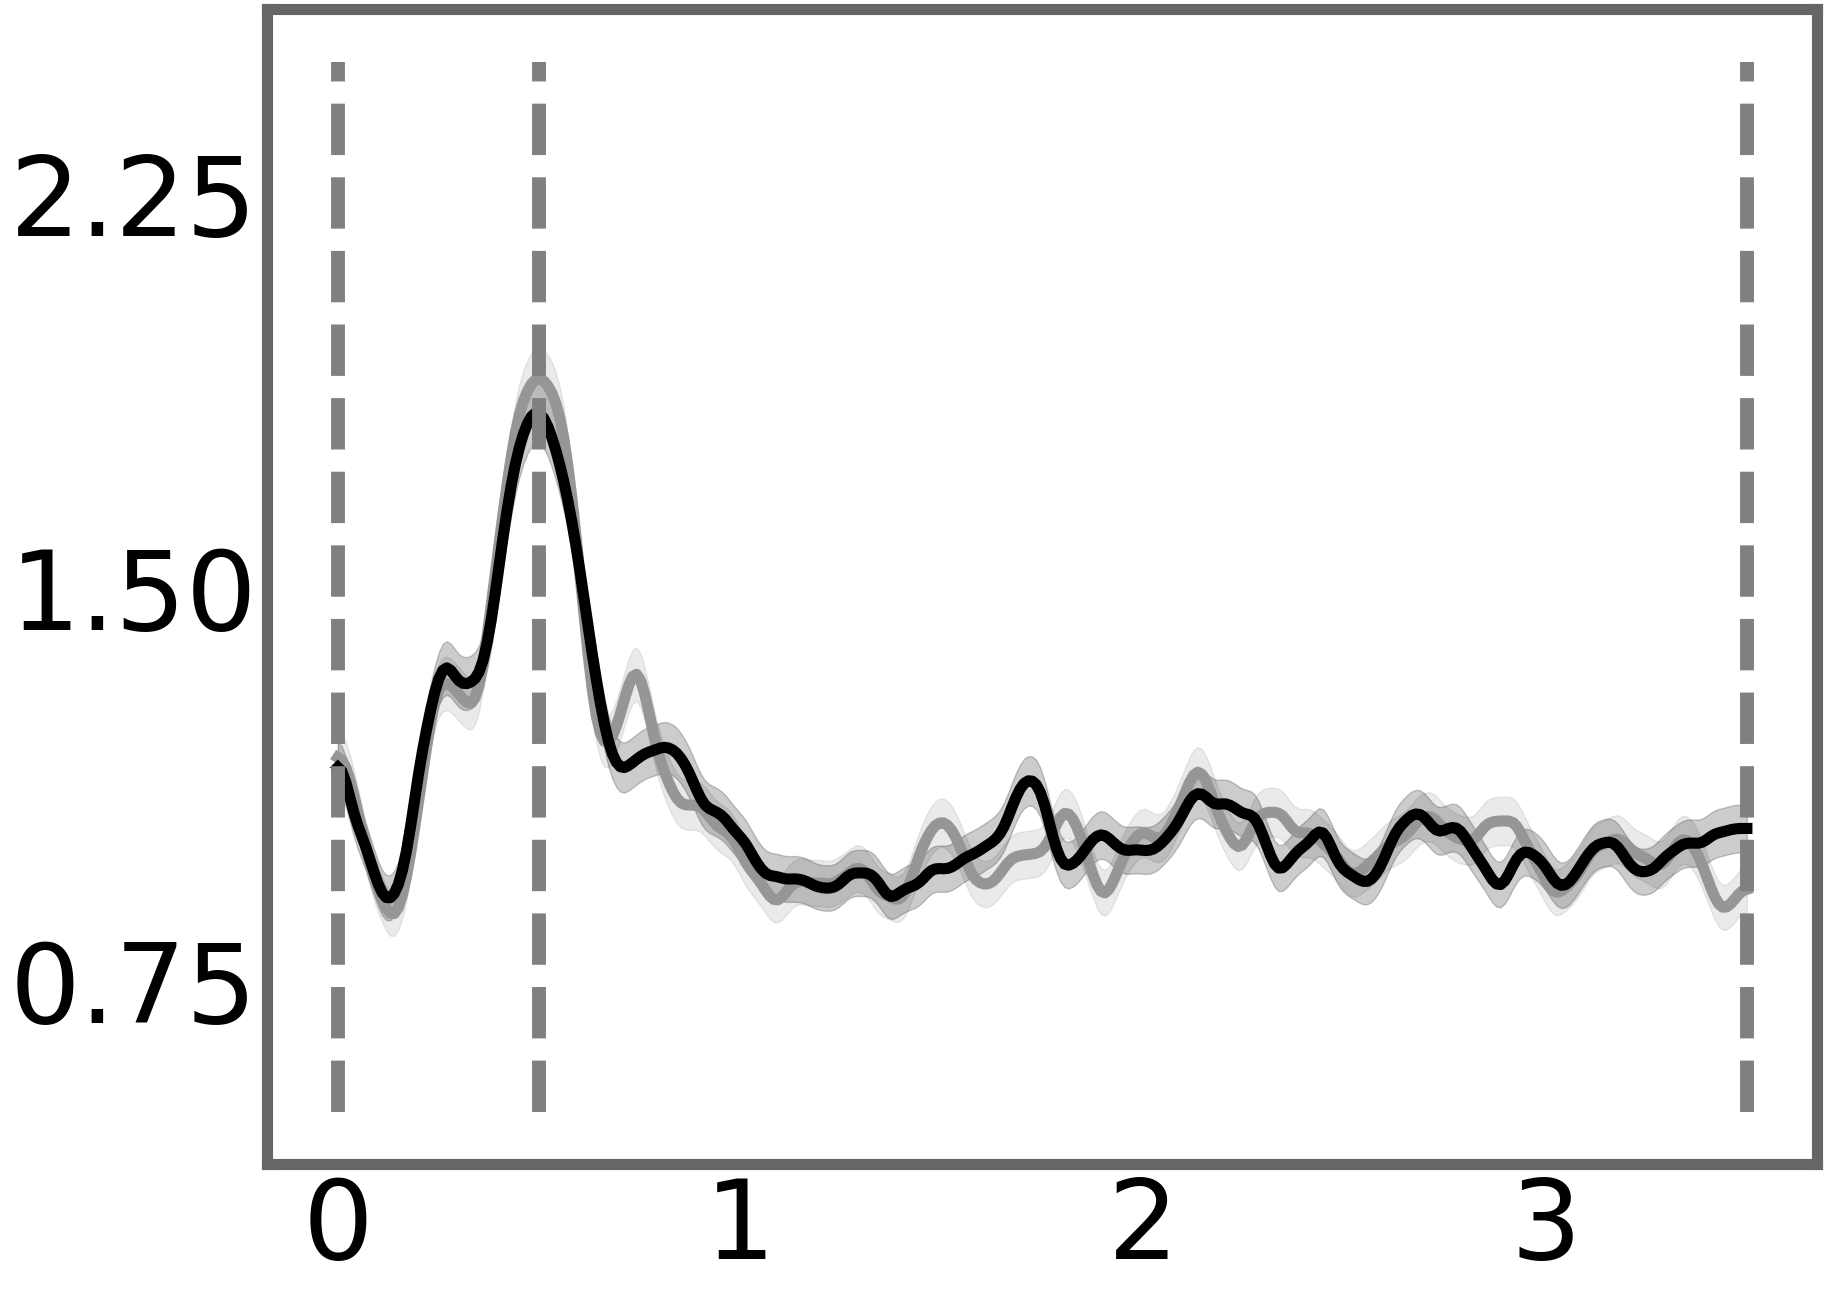

In [22]:
fs(20,15)
fig,ax = plt.subplots()

lenData = 350
x = np.linspace(0,3.5,lenData)
[plt.plot(x,smooth_signal(qq.iloc[i,4001:7501:10],11),c = ["#969696","#000000",][i%2],linestyle = ['dotted','-'][i//2],alpha=[0.8,0.8,1,1,][i],linewidth = 8) for i in [2,3]];
[plt.fill_between(x,smooth_signal(saccUpper.iloc[i,4001:7501:10]),
                       smooth_signal(saccLower.iloc[i,4001:7501:10]),alpha = 0.2,color = ["#969696","#000000",][i%2]) for i in [2,3]]
[plt.fill_between(i,2.0,2.25,color = "#949494",alpha = 0.2) for i in cluster_t]


plt.vlines([0,0.5,3.5],0.5,2.5,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=80)
plt.xticks(fontsize=80)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.75))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(8)
ax.spines['bottom'].set_linewidth(8)
ax.spines['right'].set_linewidth(8)
ax.spines['top'].set_linewidth(8)

# IPA

In [6]:
# Configuration
PROCESS_RAW = False
RESULTS_PATH = Path('Z:/yueying/psychedeLights_YueyingDong/results/ipaData')

if PROCESS_RAW:
    # Load raw pupil data
    pupil_raw_files = glob.glob(str(PUPIL_RAW_PATH / "*.csv"))
    pupil_full_trial = pd.concat(
        [pd.read_csv(f).iloc[:, 1:] for f in pupil_raw_files],
        axis=0,
        ignore_index=True
    )
    trial_indices = pupil_full_trial['TRIALID'].values
    
    # Detect and mask blinks
    blink_mask = pupil_full_trial.iloc[:, 1:].apply(
        lambda trial: detect_and_remove_blinks(
            raw_pupil=trial.astype(float),
            timestamp=np.linspace(0, len(trial) / 1000, len(trial)),
            return_mask=True,
            mad_threshold=8,
            padding_before=0.2,
            padding_after=0.2,
            cluster_tolerance=0.05
        ),
        axis=1,
        raw=True
    )
    
    masked_pupil = np.where(blink_mask, np.nan, pupil_full_trial.iloc[:, 1:])
    
    # Calculate rolling IPA (sliding window)
    ipa_rolling = calculate_rolling_ipa(
        pupil_data=masked_pupil,
        trial_index=trial_indices,
        window_size=10,
        sampling_freq=1000
    )
    
    ipa_clean = ipa_rolling.merge(
        psyFull[['TRIALID', 'cuedItemBri', 'participant', 'trlType', 'distractorType']],
        on='TRIALID'
    )
    
    # Calculate full epoch IPA (retrocue and delay period)
    ipa_full_epoch = np.apply_along_axis(
        calculate_ipa,
        axis=1,
        arr=masked_pupil[:, 4000:7500]
    )
    
    ipa_df = pd.DataFrame({'ipa': ipa_full_epoch, 'TRIALID': trial_indices})
    ipa_df = ipa_df.merge(
        psyFull[['TRIALID', 'cuedItemBri', 'participant', 'trlType', 'distractorType']],
        on='TRIALID'
    )

else:
    # Load preprocessed data
    ipa_clean = pd.read_csv(
        RESULTS_PATH / 'rollingIPA_clean_ds.csv'
    ).iloc[:, 1:]
    
    ipa_df = pd.read_csv(
        RESULTS_PATH / 'singularIPA_clean.csv'
    )

# Figure 4C

In [7]:
cList = ["#8446be","#218d23"]


In [25]:
anova_result = pg.rm_anova(data = ipa_df, within=['cuedItemBri','trlType'], subject='participant',dv = 'ipa')
anova_result

c:\Users\yud070.AD\.conda\envs\yueyingKiyonagaLab\Lib\site-packages\pingouin\distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
c:\Users\yud070.AD\.conda\envs\yueyingKiyonagaLab\Lib\site-packages\pingouin\distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,cuedItemBri,0.063189,1,43,0.063189,0.431212,0.514894,0.514894,0.000998,1.0
1,trlType,0.085406,1,43,0.085406,1.914426,0.173614,0.173614,0.001349,1.0
2,cuedItemBri * trlType,0.002832,1,43,0.002832,0.033209,0.856255,0.856255,0.000045,1.0


In [38]:
# Main effect of cuedItemBri
cued_means = ipa_df.groupby(['participant', 'cuedItemBri'])['ipa'].mean().unstack()
ttest_cued = stats.ttest_rel(cued_means['day'], cued_means['night'], nan_policy='omit')
bf_cued = pg.bayesfactor_ttest(t=ttest_cued.statistic, nx=len(cued_means), ny=len(cued_means))

# Main effect of trlType
trl_means = ipa_df.groupby(['participant', 'trlType'])['ipa'].mean().unstack()
ttest_trl = stats.ttest_rel(trl_means['verbal'], trl_means['visual'], nan_policy='omit')
bf_trl = pg.bayesfactor_ttest(t=ttest_trl.statistic, nx=len(trl_means), ny=len(trl_means))

# Interaction (your method - the correct one!)
congruency_wide = ipa_df.pivot_table(
    index=['participant', 'trlType'],
    columns='cuedItemBri',
    values='ipa',
    aggfunc='mean'
).reset_index()

congruency_wide['brightness_effect'] = congruency_wide['day'] - congruency_wide['night']

effect_by_trial = congruency_wide.pivot_table(
    index='participant',
    columns='trlType',
    values='brightness_effect'
)

ttest_interaction = stats.ttest_rel(
    effect_by_trial['verbal'], 
    effect_by_trial['visual'], 
    nan_policy='omit'
)

bf_interaction = pg.bayesfactor_ttest(
    t=ttest_interaction.statistic,
    nx=len(effect_by_trial),
    ny=len(effect_by_trial)
)

# Report all effects
print("2×2 Repeated Measures ANOVA Results")
print("="*60)
print(f"\nMain effect of cuedItemBri:")
print(f"  t = {ttest_cued.statistic:.3f}, p = {ttest_cued.pvalue:.3f}, BF₁₀ = {bf_cued:.3f}")

print(f"\nMain effect of trlType:")
print(f"  t = {ttest_trl.statistic:.3f}, p = {ttest_trl.pvalue:.3f}, BF₁₀ = {bf_trl:.3f}")

print(f"\nInteraction (cuedItemBri × trlType):")
print(f"  t = {ttest_interaction.statistic:.3f}, p = {ttest_interaction.pvalue:.3f}, BF₁₀ = {bf_interaction:.3f}")

2×2 Repeated Measures ANOVA Results

Main effect of cuedItemBri:
  t = -0.662, p = 0.511, BF₁₀ = 0.270

Main effect of trlType:
  t = 1.570, p = 0.124, BF₁₀ = 0.654

Interaction (cuedItemBri × trlType):
  t = 0.182, p = 0.856, BF₁₀ = 0.226


C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_20104\4201284987.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'cuedItemBri',y = 'ipa',order=['day','night'],
C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_20104\4201284987.py:5: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 7.5}` instead.

  sns.barplot(x = 'cuedItemBri',y = 'ipa',order=['day','night'],


(-0.8, 1.8)

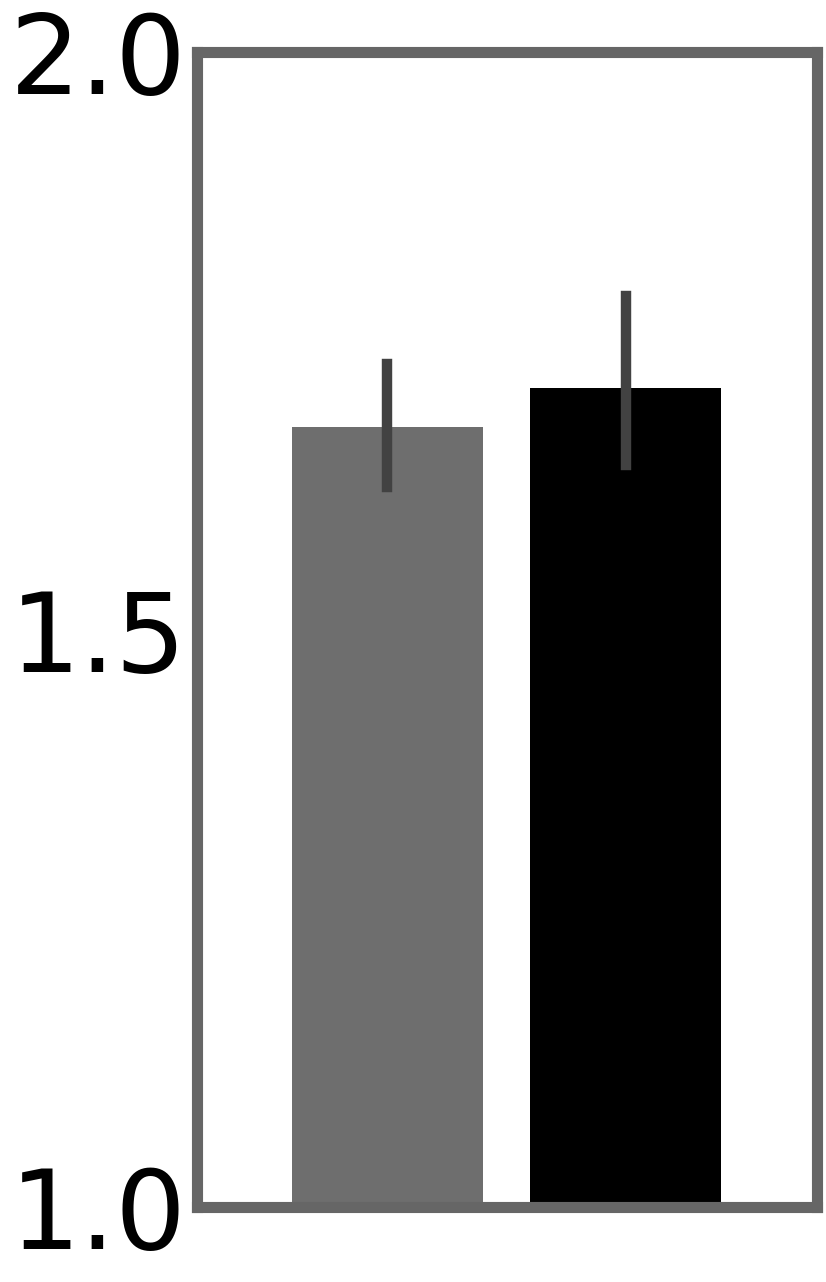

In [26]:
fs(8,15)
cList = ["#6E6E6E","#000000"]

fig,ax = plt.subplots()
sns.barplot(x = 'cuedItemBri',y = 'ipa',order=['day','night'],
            errwidth= 7.5,
            data = ipa_df,palette=cList)
plt.ylim(1,2)

ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(8)
ax.spines['bottom'].set_linewidth(8)
ax.spines['right'].set_linewidth(8)
ax.spines['top'].set_linewidth(8)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.tick_params(axis='y', which='major', labelsize=80)

plt.tick_params(axis = 'y',labelsize=80)
plt.xlabel('',c = 'white')
plt.ylabel('',c = 'white')
plt.xticks(c = 'white');

plt.xlim(-0.8, 1.8) 


C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_20104\2594424893.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'trlType',y = 'ipa',order=['visual','verbal'],
C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_20104\2594424893.py:6: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 7.5}` instead.

  sns.barplot(x = 'trlType',y = 'ipa',order=['visual','verbal'],


(-0.8, 1.8)

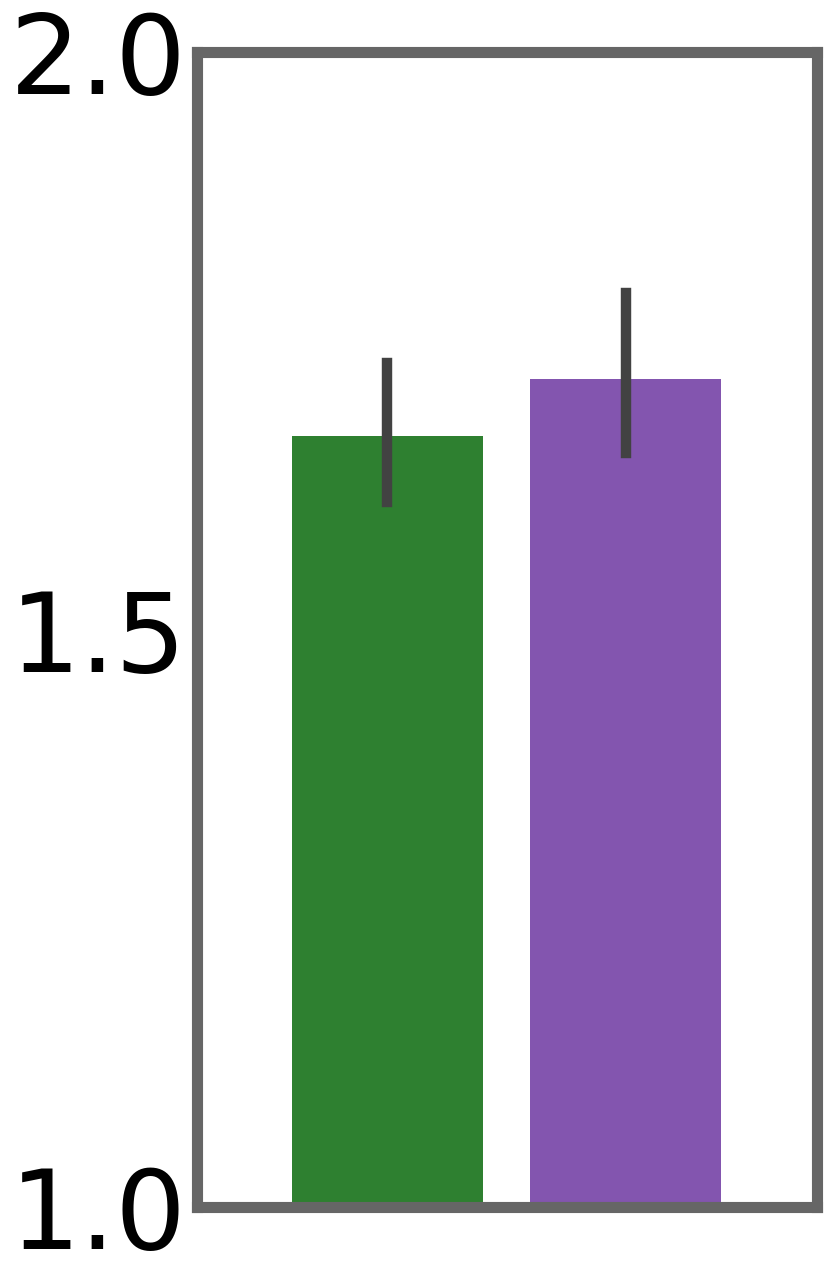

In [27]:
fs(8,15)

cList = ["#8446be","#218d23"]

fig,ax = plt.subplots()
sns.barplot(x = 'trlType',y = 'ipa',order=['visual','verbal'],
            errwidth= 7.5,
            data = ipa_df,palette=cList[::-1])
plt.ylim(1,2)

ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(8)
ax.spines['bottom'].set_linewidth(8)
ax.spines['right'].set_linewidth(8)
ax.spines['top'].set_linewidth(8)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.tick_params(axis='y', which='major', labelsize=80)

plt.tick_params(axis = 'y',labelsize=80)
plt.xlabel('',c = 'white')
plt.ylabel('',c = 'white')
plt.xticks(c = 'white');
plt.xlim(-0.8, 1.8) 


# Figure 4D

In [28]:
dataN = 34

a = ipa_clean.iloc[:,1:341]
a.columns = range(a.shape[1])
a = a.groupby(a.columns // 10, axis=1).mean()
dsIPA = pd.concat([a,ipa_clean[['trlType']]],axis = 1)

C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_20104\1486766610.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  a = a.groupby(a.columns // 10, axis=1).mean()


In [29]:
result = cluster_permutation_test(
    data_df=dsIPA,
    condition_column='trlType',
    condition_values=('visual', 'verbal'),
    n_permutations=5000,
    data_columns=slice(0, 34),  # 35 downsampled bins
    p_threshold=0.05,
    seed=42
)

Running cluster permutation test:
  Conditions: visual vs verbal
  Timepoints: 34
  Permutations: 5000
  P-threshold: 0.05

Computing observed statistics...
  Largest observed cluster: 1 timepoints (indices 19-19), statistic=-2.788
  Largest observed cluster: 1 timepoints (indices 19-19), statistic=-2.788

Running 5000 permutations...
  Progress: 1000/5000
  Progress: 2000/5000
  Progress: 3000/5000
  Progress: 4000/5000
  Progress: 5000/5000

RESULTS:
  Observed largest cluster statistic: -2.788
  Permutation p-value: 0.1760


In [30]:
cluster_pvalues = [
    np.mean(cluster_stat > result['null_distribution'])
    for cluster_stat in [result['observed_stats'][cluster].sum() 
                         for cluster in result['observed_clusters']]
]

cluster_t = [time for time, p in zip(result['observed_clusters'], cluster_pvalues) if p < 0.05]
cluster_t = [(i[0]/10,i[-1]/10+0.1) #since the array starts at 0, plus 0.1
    for i in cluster_t]

print("Cluster p-values:", cluster_pvalues)
print("Clusters:", cluster_t)

Cluster p-values: [0.0912]
Clusters: []


In [31]:
ipaRollingMean = ipa_clean.drop(['TRIALID'],axis = 1).groupby(['trlType',]).mean(numeric_only=True).iloc[:,:-1]
ipaRollingSd = ipa_clean.drop(['TRIALID'],axis = 1).groupby(['trlType',]).sem(numeric_only=True).iloc[:,:-1]
ipaRollingUpper = ipaRollingMean + ipaRollingSd
ipaRollingLower = ipaRollingMean - ipaRollingSd

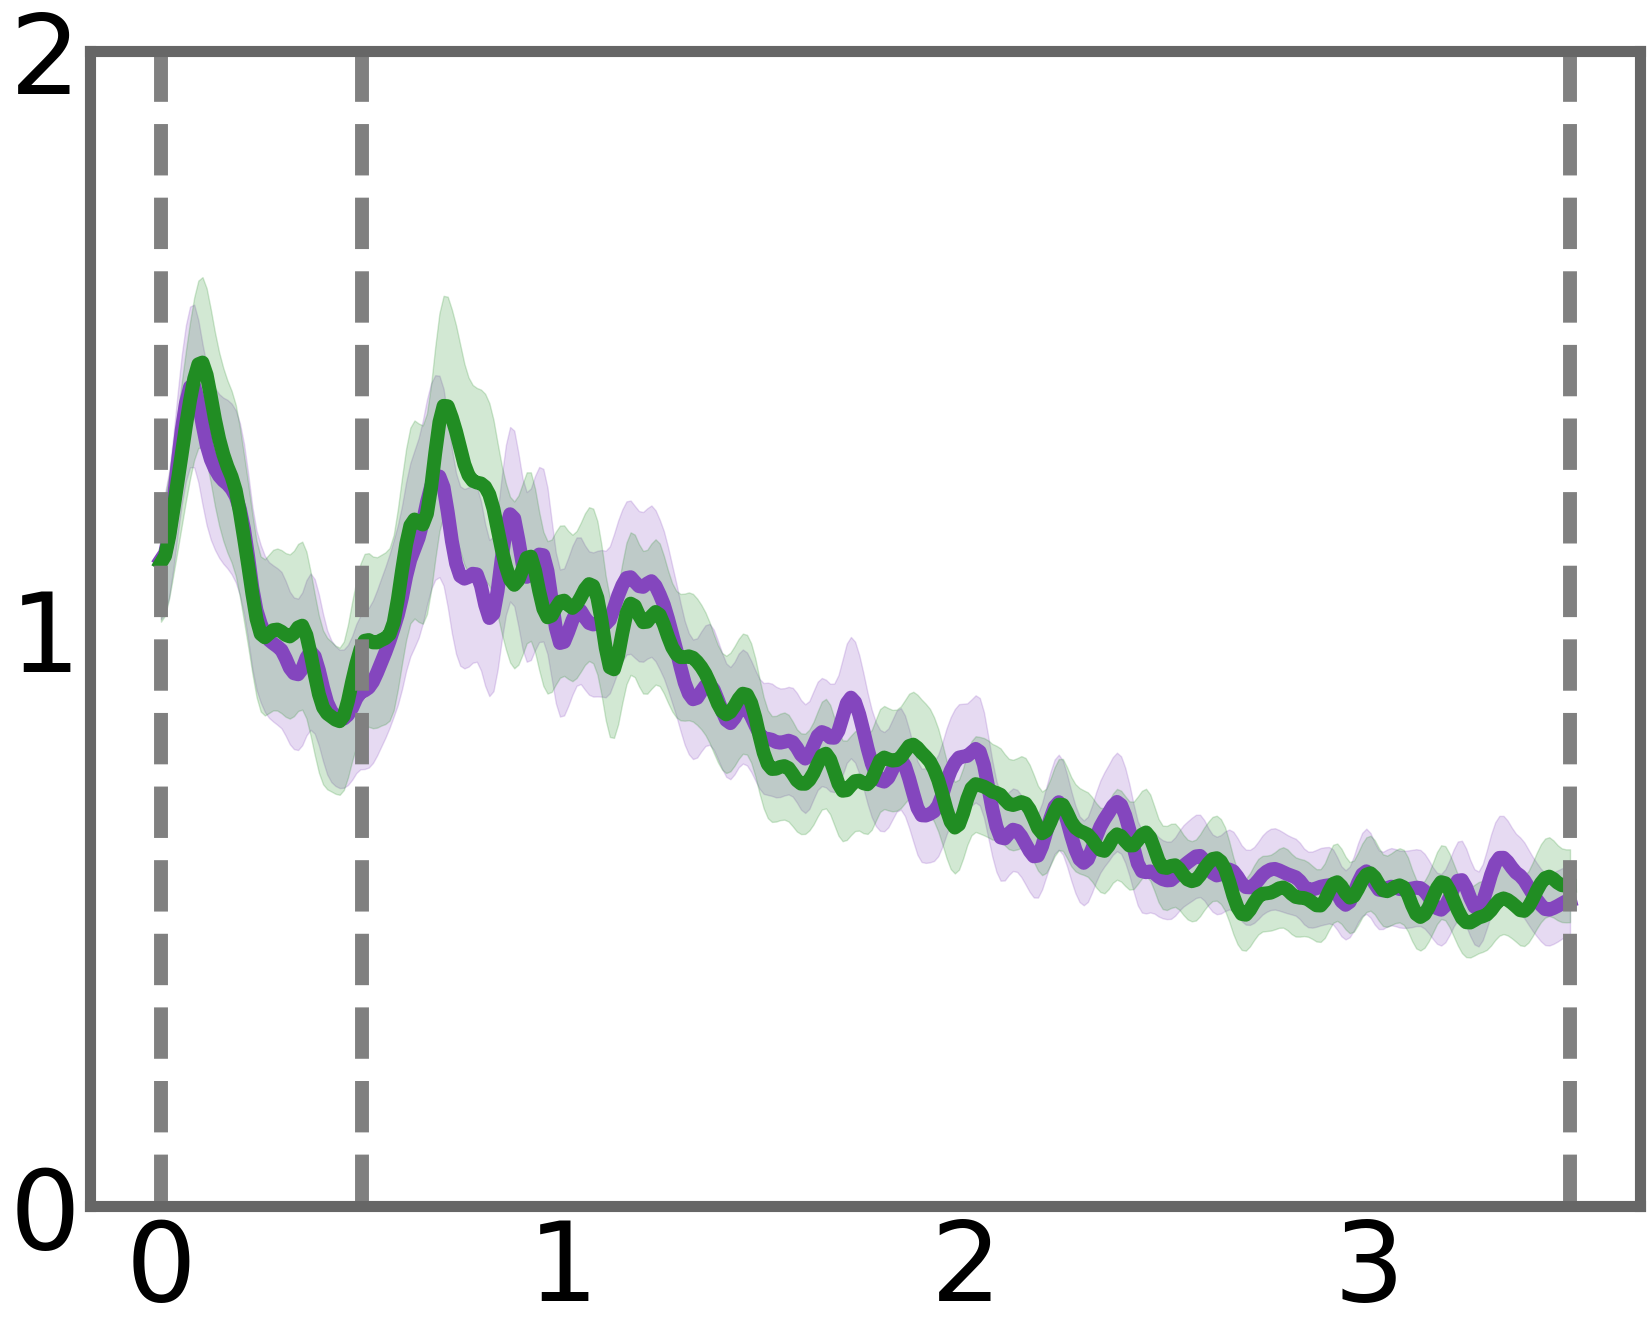

In [32]:
fs(20,15)
lenData = 340
x = np.linspace(0,3.5,lenData)
fig,ax = plt.subplots()

[plt.plot(x,smooth_signal(ipaRollingMean.iloc[i,:lenData],11),c = cList[i],linewidth = 10) for i in range(2)]
[plt.fill_between(x,smooth_signal(ipaRollingUpper.iloc[i,:lenData]),smooth_signal(ipaRollingLower.iloc[i,:lenData]),alpha = 0.2,color = cList[i]) for i in range(2)]
[plt.fill_between(i,1.5,2,color = "#949494",alpha = 0.2) for i in cluster_t]

plt.vlines([0,0.5,3.5],0,2.5,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=80)
plt.xticks(fontsize=80)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.ylim(0,2)
plt.subplots_adjust(wspace=0.28)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(8)
ax.spines['bottom'].set_linewidth(8)
ax.spines['right'].set_linewidth(8)
ax.spines['top'].set_linewidth(8)


In [33]:
dsIPA = pd.concat([a,ipa_clean[['cuedItemBri']]],axis = 1)
result = cluster_permutation_test(
    data_df=dsIPA,
    condition_column='cuedItemBri',
    condition_values=('day', 'night'),
    n_permutations=5000,
    data_columns=slice(0, 34),  # 35 downsampled bins
    p_threshold=0.05,
    seed=42
)

Running cluster permutation test:
  Conditions: day vs night
  Timepoints: 34
  Permutations: 5000
  P-threshold: 0.05

Computing observed statistics...
  Largest observed cluster: 1 timepoints (indices 26-26), statistic=-2.441
  Largest observed cluster: 1 timepoints (indices 26-26), statistic=-2.441

Running 5000 permutations...
  Progress: 1000/5000
  Progress: 2000/5000
  Progress: 3000/5000
  Progress: 4000/5000
  Progress: 5000/5000

RESULTS:
  Observed largest cluster statistic: -2.441
  Permutation p-value: 0.3844


In [34]:
cluster_pvalues = [
    np.mean(cluster_stat > result['null_distribution'])
    for cluster_stat in [result['observed_stats'][cluster].sum() 
                         for cluster in result['observed_clusters']]
]

cluster_t = [time for time, p in zip(result['observed_clusters'], cluster_pvalues) if p < 0.05]
cluster_t = [(i[0]/10,i[-1]/10+0.1) #since the array starts at 0, plus 0.1
    for i in cluster_t]

print("Cluster p-values:", cluster_pvalues)
print("Clusters:", cluster_t)

Cluster p-values: [0.7642, 0.1854]
Clusters: []


In [35]:
ipaRollingMean = ipa_clean.drop(['TRIALID'],axis = 1).groupby(['cuedItemBri',]).mean(numeric_only=True).iloc[:,:-1]
ipaRollingSd = ipa_clean.drop(['TRIALID'],axis = 1).groupby(['cuedItemBri',]).sem(numeric_only=True).iloc[:,:-1]
ipaRollingUpper = ipaRollingMean + ipaRollingSd
ipaRollingLower = ipaRollingMean - ipaRollingSd

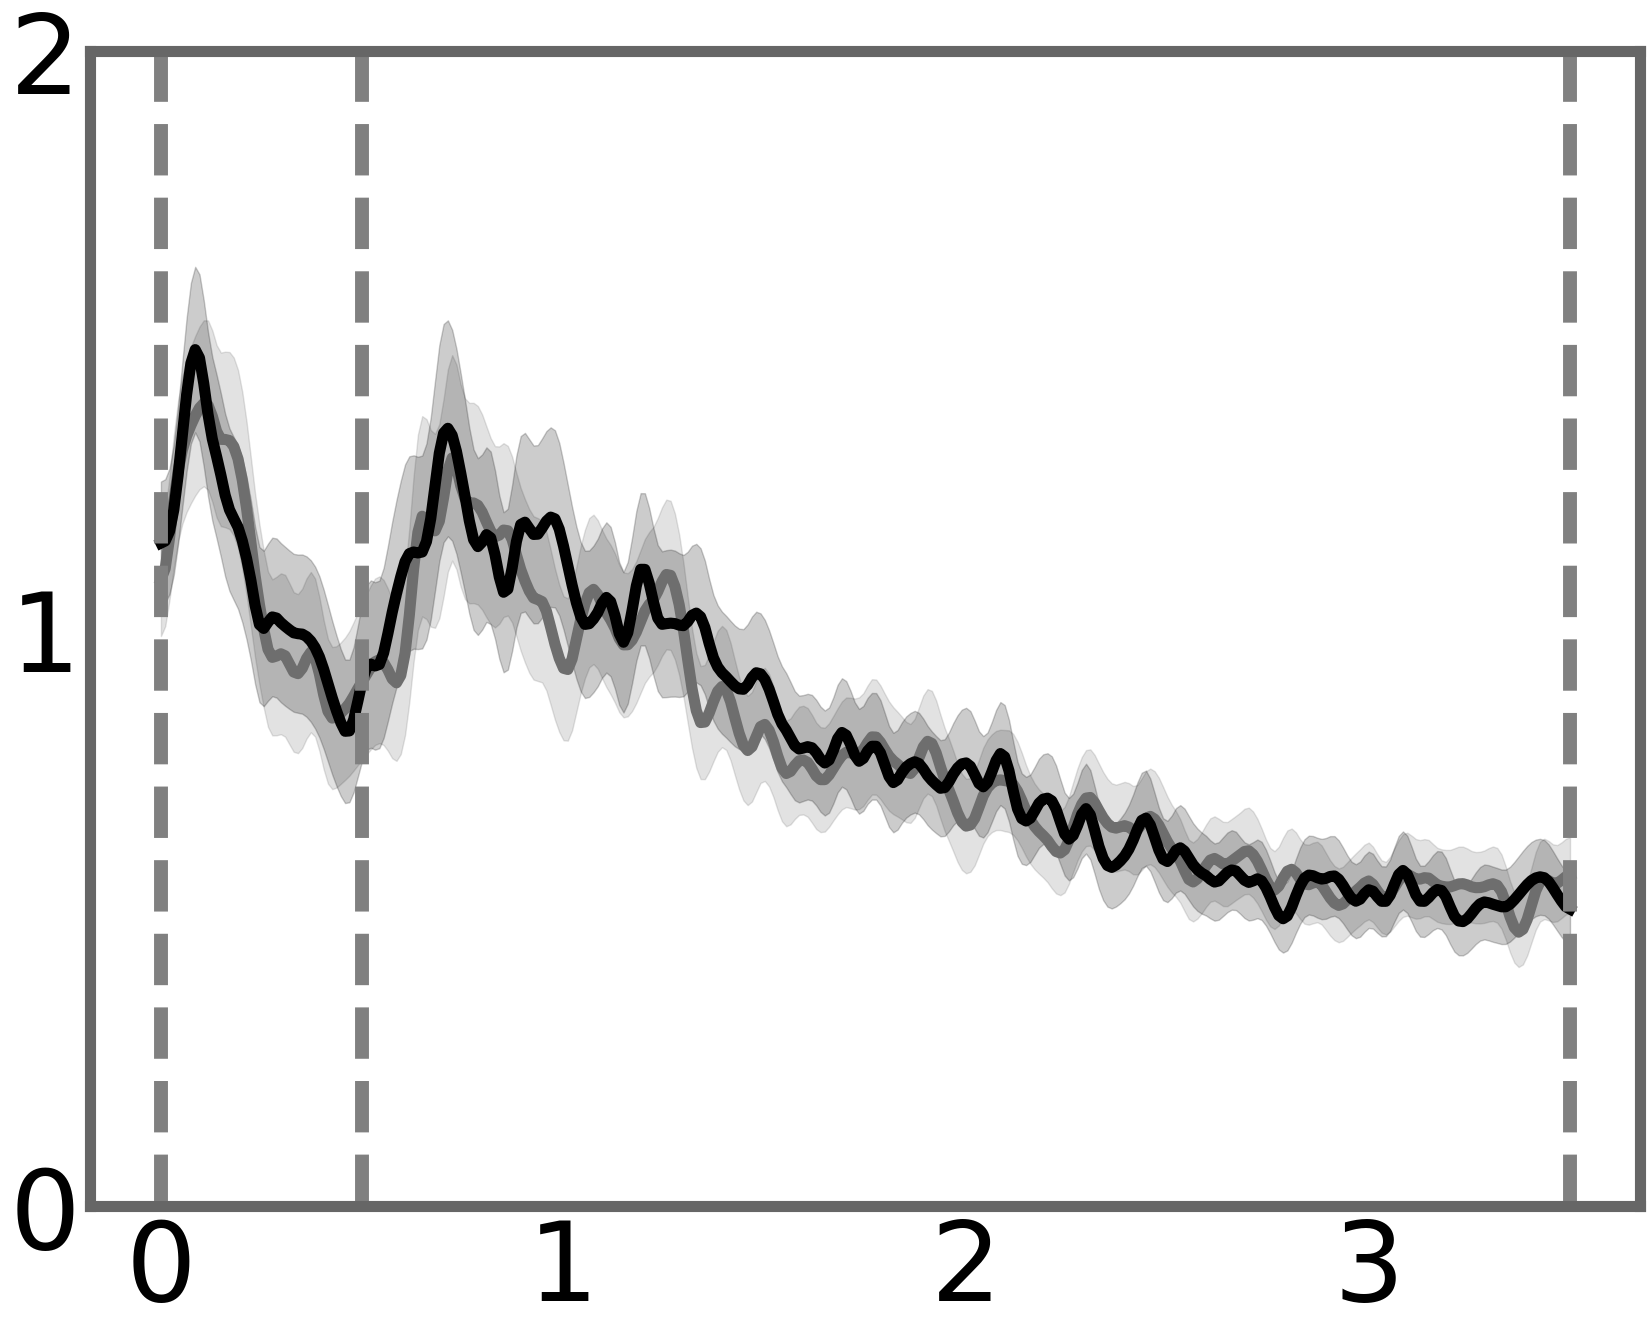

In [36]:
cList = ["#6E6E6E","#000000"]
fs(20,15)
lenData = 330
x = np.linspace(0,3.5,lenData)
fig,ax = plt.subplots()

[plt.plot(x,smooth_signal(ipaRollingMean.iloc[i,:lenData],11),c = cList[i],linewidth = 8) for i in range(2)]
[plt.fill_between(x,smooth_signal(ipaRollingUpper.iloc[i,:lenData]),smooth_signal(ipaRollingLower.iloc[i,:lenData]),alpha = 0.2,color = cList[i]) for i in range(2)]

plt.vlines([0,0.5,3.5],0,2.5,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=80)
plt.xticks(fontsize=80)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1));
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.ylim(0,2)


plt.subplots_adjust(wspace=0.28)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(8)
ax.spines['bottom'].set_linewidth(8)
ax.spines['right'].set_linewidth(8)
ax.spines['top'].set_linewidth(8)
